# DIRECTi tutorial

In [1]:
import time
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.logging.set_verbosity(0)

import Cell_BLAST as cb
cb.config.N_JOBS = 4
cb.config.RANDOM_SEED = 0

## Unsupervised dimension reduction

Let's first load a dataset (*Baron, M. et al. Cell Syst, 2016*), which profiles >8,000 human pancreatic islet cells.

Here we normalized the dataset so that the resulting model, once fitted, can be used to project other datasets normalized in the same way.

> Theoretically speaking, read count distribution may deviate from negative binomial due to the scaling, but practically it still fits very well.

In [2]:
baron_human = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Baron_human/data.h5").normalize()

Now we build and fit a DIRECTi model with the one-step `fit_DIRECTi` function.

We set latent space dimensionality to 10, and go with 20 intrinsic clusters.

To save time, we only train for 50 epochs. The model has not fully converged but already works well.

In [3]:
%%capture
model = cb.directi.fit_DIRECTi(
    baron_human, baron_human.uns["seurat_genes"],
    latent_dim=10, cat_dim=20, epoch=50,
    path="./baron_human_model"
)

We can project cells into the low dimensional latent space using the `inference` method.
It is recommended that you store the returned latent space into the `latent` slot of the original dataset object, which facilitates visualization.

In [4]:
baron_human.latent = model.inference(baron_human)

[  Info   ] Using cached tSNE...


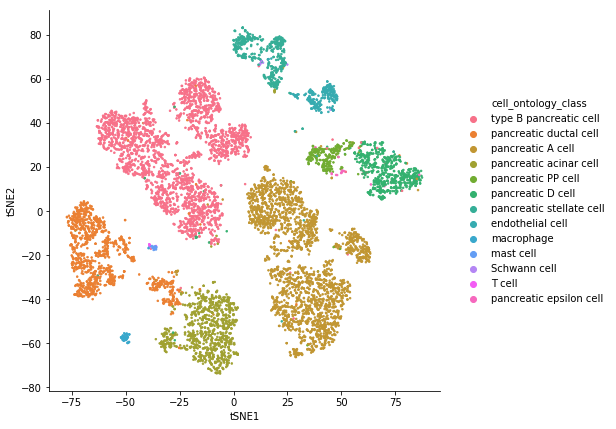

In [6]:
ax = baron_human.visualize_latent("cell_ontology_class")

We see that different cell types can readily be distinguished.

Note that though 20-dimensional categorical latent was used, far less clusters form in the latent space. This is because the model is flexible to discard categories or to use multiple categories to represent the same cluster if a redundant number of categories is specified.

You can also save the model for future use. It is straightforward to load a saved model.

In [7]:
model.save()
model.close()
del model
model = cb.directi.DIRECTi.load("./baron_human_model")

[  Info   ] Loading latent module weights...
[  Info   ] Loading prob module weights...
[  Info   ] Loading rmbatch module weights...


We can also project other datasets with the same model. Here we test with the Muraro dataset (*Muraro, M. et al. Cell Systems, 2016*)

There will be a warning saying that we have some genes missing in the new dataset, but it doesn't really matter. Distinct cell types are still well separated.

[ Warning ] 18 out of 769 variables are not found, will be set to zero!
[  Info   ] Computing tSNE...


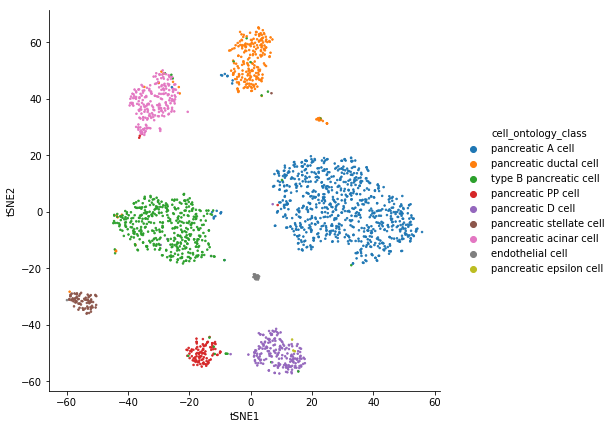

In [8]:
muraro = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Muraro/data.h5").normalize()
muraro.latent = model.inference(muraro)
ax = muraro.visualize_latent("cell_ontology_class")

## Systematical bias / batch effect removal

If we train on a "meta" dataset merged from multiple datasets, we'll find significant systematical bias among them.

In [9]:
combined_dataset = cb.data.ExprDataSet.merge_datasets({
    "Baron_human": cb.data.ExprDataSet.read_dataset("../../Datasets/data/Baron_human/data.h5"),
    "Segerstolpe": cb.data.ExprDataSet.read_dataset("../../Datasets/data/Segerstolpe/data.h5"),
    "Muraro": cb.data.ExprDataSet.read_dataset("../../Datasets/data/Muraro/data.h5"),
    "Xin": cb.data.ExprDataSet.read_dataset("../../Datasets/data/Xin_2016/data.h5"),
    "Lawlor": cb.data.ExprDataSet.read_dataset("../../Datasets/data/Lawlor/data.h5")
}, meta_col="study", merge_uns_slots=["seurat_genes"]).normalize()

[ Warning ] 22569 out of 42694 variables are not found, will be set to zero!
[ Warning ] 17241 out of 42694 variables are not found, will be set to zero!
[ Warning ] 23648 out of 42694 variables are not found, will be set to zero!
[ Warning ] 2843 out of 42694 variables are not found, will be set to zero!
[ Warning ] 22809 out of 42694 variables are not found, will be set to zero!
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...


In [10]:
%%capture
model = cb.directi.fit_DIRECTi(
    combined_dataset, combined_dataset.uns["seurat_genes"],
    latent_dim=10, cat_dim=20, epoch=20,
    path="/tmp/cb/examples/pancreas_unaligned_model"
)
combined_dataset.latent = model.inference(combined_dataset)

[  Info   ] Computing tSNE...


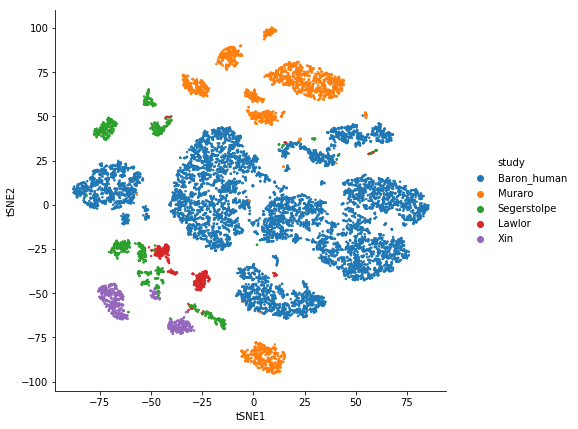

In [11]:
ax = combined_dataset.visualize_latent("study")

You can remove the systematical bias from the latent space simply by specifying a `batch_effect` column, which is "study" in this case.

This time we train the model for 100 epoches to get better convergence.

In [12]:
%%capture
model_rmbatch = cb.directi.fit_DIRECTi(
    combined_dataset, combined_dataset.uns["seurat_genes"], batch_effect="study", 
    latent_dim=10, cat_dim=20, epoch=100,
    path="/tmp/cb/examples/pancreas_aligned_model"
)
combined_dataset.latent = model_rmbatch.inference(combined_dataset)

We see that systematical bias is largely removed. Cells of the same cell type from different studies are well aligned.

[  Info   ] Computing tSNE...


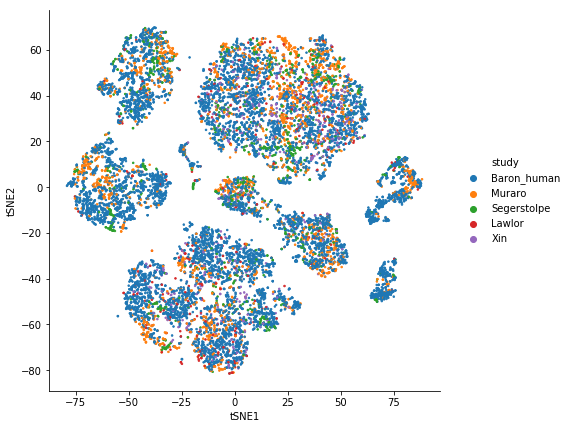

In [13]:
ax = combined_dataset.visualize_latent("study")

[  Info   ] Using cached tSNE...


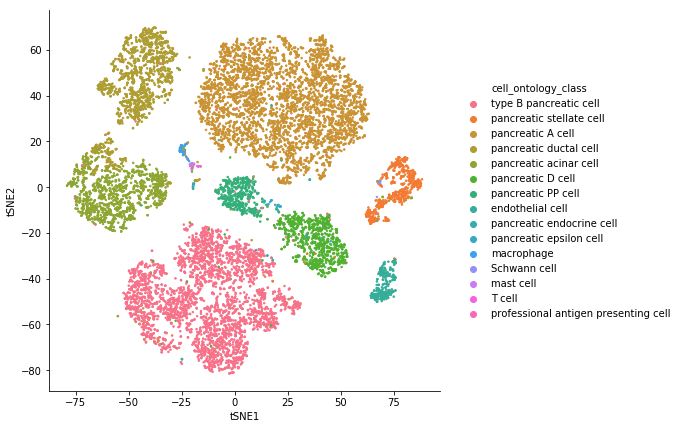

In [14]:
ax = combined_dataset.visualize_latent("cell_ontology_class")